# wetterdienst - A simple example

pip install wetterdienst

## Import modules necessary for general functioning

In [1]:
import warnings
warnings.filterwarnings("ignore")

from wetterdienst.dwd.observations import DWDObservationMetadata, DWDObservationStations, \
    DWDObservationValues, DWDObservationPeriod, DWDObservationResolution, \
    DWDObservationParameter, DWDObservationParameterSet

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

Which parameters are available?

In [2]:
# all
print("All available combinations")
print(
    DWDObservationMetadata().discover_parameters()
)
# selection
print("Selection of daily historical data")
print(
    DWDObservationMetadata(
        resolution=DWDObservationResolution.DAILY,
        period=DWDObservationPeriod.HISTORICAL
    ).discover_parameters()
)

All available combinations
{'MINUTE_1': ['PRECIPITATION_HEIGHT', 'PRECIPITATION_HEIGHT_DROPLET', 'PRECIPITATION_HEIGHT_ROCKER', 'PRECIPITATION_FORM'], 'MINUTE_10': ['PRESSURE_AIR_STATION_HEIGHT', 'TEMPERATURE_AIR_200', 'TEMPERATURE_AIR_005', 'HUMIDITY', 'TEMPERATURE_DEW_POINT_200', 'TEMPERATURE_AIR_MAX_200', 'TEMPERATURE_AIR_MAX_005', 'TEMPERATURE_AIR_MIN_200', 'TEMPERATURE_AIR_MIN_005', 'WIND_GUST_MAX', 'WIND_SPEED_MIN', 'WIND_SPEED_ROLLING_MEAN_MAX', 'WIND_DIRECTION_MAX_VELOCITY', 'PRECIPITATION_DURATION', 'PRECIPITATION_HEIGHT', 'PRECIPITATION_INDICATOR_WR', 'RADIATION_SKY_DIFFUSE', 'RADIATION_GLOBAL', 'SUNSHINE_DURATION', 'RADIATION_SKY_LONG_WAVE', 'WIND_SPEED', 'WIND_DIRECTION'], 'HOURLY': ['TEMPERATURE_AIR_200', 'HUMIDITY', 'CLOUD_COVER_TOTAL', 'CLOUD_COVER_TOTAL_INDICATOR', 'CLOUD_TYPE_LAYER1', 'CLOUD_TYPE_LAYER1_ABBREVIATION', 'CLOUD_HEIGHT_LAYER1', 'CLOUD_COVER_LAYER1', 'CLOUD_TYPE_LAYER2', 'CLOUD_TYPE_LAYER2_ABBREVIATION', 'CLOUD_HEIGHT_LAYER2', 'CLOUD_COVER_LAYER2', 'CLOUD_T

## 1. First check the metadata to inform yourself of available stations
(here we pick historical daily precipitation - hdp)

In [3]:
sites_hdp = DWDObservationStations(
    parameter=DWDObservationParameterSet.PRECIPITATION_MORE,
    resolution=DWDObservationResolution.DAILY,
    period=DWDObservationPeriod.HISTORICAL
)
print("Number of stations with available data: ", sites_hdp.all().sum())
print("Some of the stations:")
sites_hdp.all().head()

Number of stations with available data:  STATION_ID      0000100002000030000400006000070000800009000100...
HEIGHT                                                1.61506e+06
LATITUDE                                                   285395
LONGITUDE                                                 58625.6
STATION_NAME    AachAachen (Kläranlage)AachenAachen-BrandAalen...
STATE           Baden-WürttembergNordrhein-WestfalenNordrhein-...
dtype: object
Some of the stations:


,STATION_ID,FROM_DATE,TO_DATE,HEIGHT,LATITUDE,LONGITUDE,STATION_NAME,STATE
0,00001,1912-01-01 00:00:00+00:00,1986-06-30 00:00:00+00:00,478.0,47.8413,8.8493,Aach,Baden-Württemberg
1,00002,1951-01-01 00:00:00+00:00,2006-12-31 00:00:00+00:00,138.0,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen
2,00003,1891-01-01 00:00:00+00:00,2011-03-31 00:00:00+00:00,202.0,50.7827,6.0941,Aachen,Nordrhein-Westfalen
3,00004,1951-01-01 00:00:00+00:00,1979-10-31 00:00:00+00:00,243.0,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen
4,00006,1982-11-01 00:00:00+00:00,2021-02-03 00:00:00+00:00,455.0,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg


The metadata includes an id, the range of the measurements, the position
(including height) as well as place and state of it and if it has a file. With the
following plot we want to show a map of those stations:

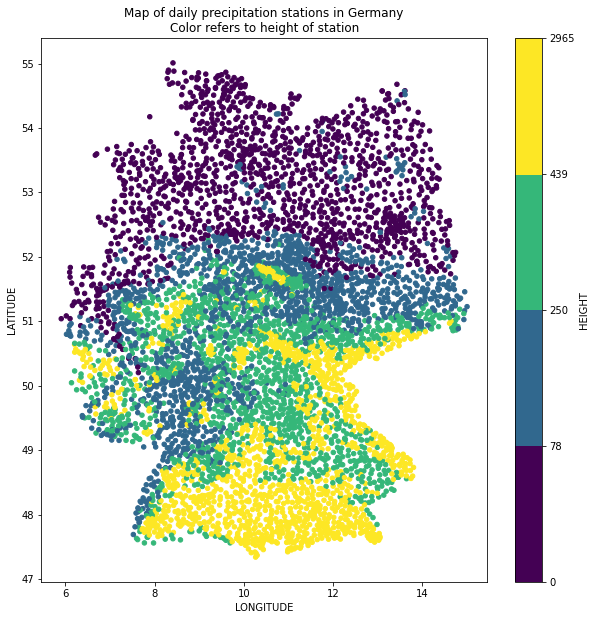

In [4]:
cmap = cm.get_cmap('viridis')
bounds = sites_hdp.all().HEIGHT.quantile([0, 0.25, 0.5, 0.75, 1]).values
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 10))
plot = sites_hdp.all().plot.scatter(
    x="LONGITUDE", y="LATITUDE", c="HEIGHT", cmap=cmap, norm=norm, ax=ax)
plot.set_title("Map of daily precipitation stations in Germany\n"
               "Color refers to height of station")
plt.show()

## 2. The usual way of retrieving data

Usually there are three steps to follow:
- select indexed files based on
    - its station_id
        - "1048" for Dresden, Germany
    - its parameter
        - "kl" for climate
    - its time_resolution
        - "daily" for daily data
    - its period_type
        - "historical" for data up to the end of the last year
- download the resulting list of files
- parse it into pandas.DataFrames

We have summarized those steps into one:
- collect_dwd_data

Let's try it out for the above selection:

In [5]:
print("Receiving historical daily climate data for Dresden-Klotzsche (1048)")
station_data = DWDObservationValues(
    station_id=[1048],
    parameter=[DWDObservationParameterSet.CLIMATE_SUMMARY],
    resolution=DWDObservationResolution.DAILY,
    period=[DWDObservationPeriod.HISTORICAL],
    tidy_data=False
).all()

station_data.dropna(axis=0).head()

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Receiving historical daily climate data for Dresden-Klotzsche (1048)


,STATION_ID,DATE,QN_3,WIND_GUST_MAX,WIND_SPEED,QN_4,PRECIPITATION_HEIGHT,PRECIPITATION_FORM,SUNSHINE_DURATION,SNOW_DEPTH,CLOUD_COVER_TOTAL,PRESSURE_VAPOR,PRESSURE_AIR,TEMPERATURE_AIR_200,HUMIDITY,TEMPERATURE_AIR_MAX_200,TEMPERATURE_AIR_MIN_200,TEMPERATURE_AIR_MIN_005
8826,01048,1973-01-01 00:00:00+00:00,5,15.0,6.0,5,0.0,0.0,7.0,0.0,0.4,3.4,1001.8,1.1,51.0,4.0,-1.1,-2.9
8827,01048,1973-01-02 00:00:00+00:00,5,12.0,2.8,5,0.0,0.0,6.5,0.0,0.0,3.7,1001.5,0.4,59.0,5.3,-0.8,-2.6
8830,01048,1973-01-05 00:00:00+00:00,5,6.0,1.6,5,0.4,1.0,0.0,0.0,8.0,5.4,1010.0,-1.0,94.0,0.1,-1.9,-2.2
8835,01048,1973-01-10 00:00:00+00:00,5,6.0,1.9,5,0.1,1.0,0.0,0.0,7.9,6.2,1002.4,0.7,97.0,1.5,0.4,0.3
8836,01048,1973-01-11 00:00:00+00:00,5,7.0,2.5,5,0.4,1.0,0.0,0.0,8.0,6.6,1002.4,1.6,96.0,2.1,0.1,0.0


See that DATE is already parsed, so we can easily get some nice graphs with matplotlib,
which we will do in the next part. We may as well also use the "tidy_data" option to
receive a nicer dataframe and "humanize_column_names" to get meaningful parameters:

In [6]:
print("Receiving historical daily climate data for Dresden-Klotzsche (1048), this time tidied.")
station_data = DWDObservationValues(
    station_id=[1048],
    parameter=[DWDObservationParameterSet.CLIMATE_SUMMARY],
    resolution=DWDObservationResolution.DAILY,
    period=[DWDObservationPeriod.HISTORICAL],
    tidy_data=True,
    humanize_parameters=True
).all()

station_data.dropna(axis=0).groupby("PARAMETER").first()


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Receiving historical daily climate data for Dresden-Klotzsche (1048), this time tidied.


,STATION_ID,DATE,PARAMETER_SET,VALUE,QUALITY
PARAMETER,,,,,
WIND_SPEED,01048,1973-01-01 00:00:00+00:00,CLIMATE_SUMMARY,6.0,5
WIND_GUST_MAX,01048,1973-01-01 00:00:00+00:00,CLIMATE_SUMMARY,15.0,5
CLOUD_COVER_TOTAL,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,8.0,1
PRESSURE_AIR,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,1008.6,1
PRECIPITATION_HEIGHT,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,0.2,1
PRECIPITATION_FORM,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,8.0,1
SUNSHINE_DURATION,01048,1935-02-01 00:00:00+00:00,CLIMATE_SUMMARY,0.6,1
SNOW_DEPTH,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,0.0,1
TEMPERATURE_AIR_MIN_005,01048,1935-09-01 00:00:00+00:00,CLIMATE_SUMMARY,12.9,1


With the latest update we can now also request direct parameters from the given sets.
We know that climate_summary contains TMK, TNK, TXK and RSK, so let's request those.
This option will automatically tidy the data.

In [7]:
print("Receiving historical daily temperature and precipitation for Dresden-Klotzsche "
      "(1048).")
station_data = DWDObservationValues(
    station_id=[1048],
    parameter=[
        DWDObservationParameter.DAILY.TEMPERATURE_AIR_200,
        DWDObservationParameter.DAILY.TEMPERATURE_AIR_MAX_200,
        DWDObservationParameter.DAILY.TEMPERATURE_AIR_MIN_200,
        DWDObservationParameter.DAILY.PRECIPITATION_HEIGHT
    ],
    resolution=DWDObservationResolution.DAILY,
    period=[DWDObservationPeriod.HISTORICAL],
    humanize_parameters=False
).all()

station_data.dropna(axis=0).head()

100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Receiving historical daily temperature and precipitation for Dresden-Klotzsche (1048).


,STATION_ID,DATE,PARAMETER_SET,PARAMETER,VALUE,QUALITY
0,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,TMK,0.5,1
1,01048,1934-01-02 00:00:00+00:00,CLIMATE_SUMMARY,TMK,-0.1,1
2,01048,1934-01-03 00:00:00+00:00,CLIMATE_SUMMARY,TMK,-0.7,1
3,01048,1934-01-04 00:00:00+00:00,CLIMATE_SUMMARY,TMK,-1.6,1
4,01048,1934-01-05 00:00:00+00:00,CLIMATE_SUMMARY,TMK,0.9,1


## 3. Let's create some plots

Now that we have data, let's create some plots! We can create a time series/histogram of
the temperatures and precipitation

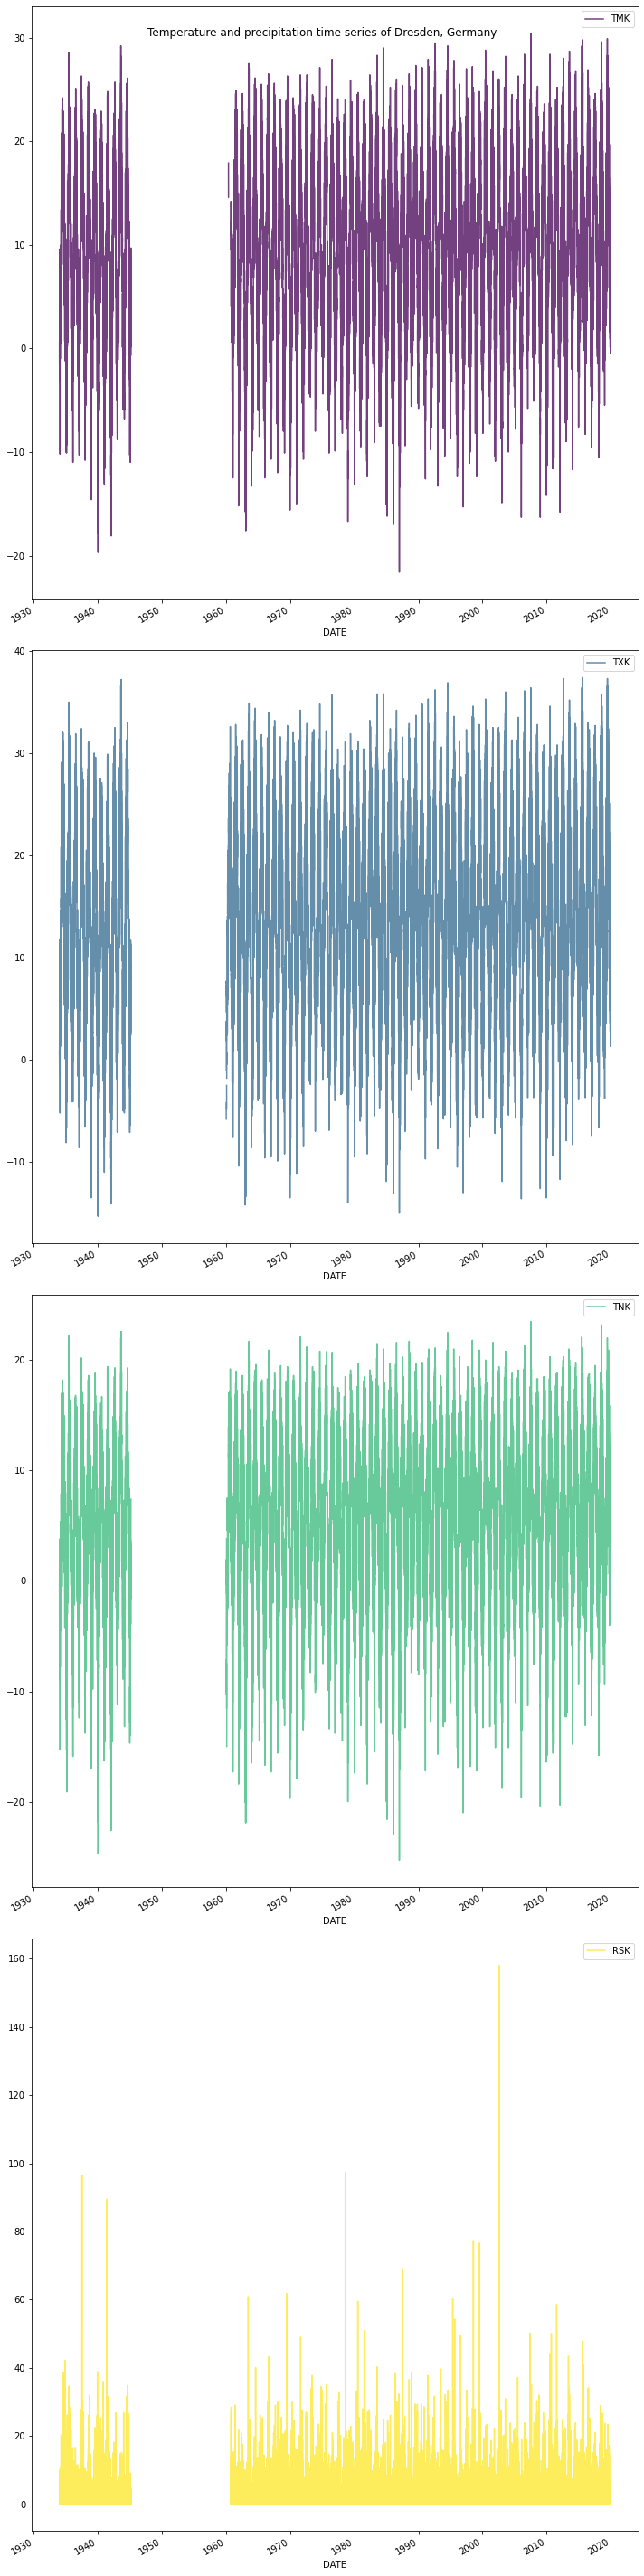

In [8]:
cmap = plt.get_cmap('viridis', 4)
colors = cmap.colors

PARAMETERS = ["TNK", "TMK", "TXK", "RSK"]

station_data_grouped = station_data.groupby(station_data["PARAMETER"], observed=True)

fig, axes = plt.subplots(nrows=len(PARAMETERS), tight_layout=True, figsize=(10, 40))

for (parameter, group), ax, color in zip(station_data_grouped, axes, colors):
    group.plot(x="DATE", y="VALUE", label=parameter, alpha=.75, ax=ax, c=color)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Temperature and precipitation time series of Dresden, Germany")

plt.show()

## 4. Create yearly values

In [9]:
import numpy as np
import pandas as pd
station_data_yearly = []

for (year, parameter), group in station_data.groupby(
        [station_data["DATE"].dt.year, "PARAMETER"], as_index=False, observed=True):
    if parameter == "RSK":
        station_data_yearly.append(group.dropna().agg({"VALUE": np.sum}))
    else:
        station_data_yearly.append(group.dropna().agg({"VALUE": np.mean}))

station_data_yearly = pd.concat(station_data_yearly)

station_data_yearly

VALUE     10.645479
VALUE     14.985479
VALUE      5.540548
VALUE    675.600000
VALUE      9.053425
            ...    
VALUE    421.100000
VALUE     11.229041
VALUE     15.583836
VALUE      6.808493
VALUE    503.300000
Length: 288, dtype: float64

## 5. Find a station

We may want to find a station near to a certain area. Therefor simply call get_nearest_station

In [10]:
DWDObservationStations(
    parameter=DWDObservationParameterSet.CLIMATE_SUMMARY,
    resolution=DWDObservationResolution.DAILY,
    period=DWDObservationPeriod.HISTORICAL,
    start_date="2000-01-01",
    end_date="2010-01-01"
).nearby_number(
    51.05089,
    13.73832,
    5
)

,STATION_ID,FROM_DATE,TO_DATE,HEIGHT,LATITUDE,LONGITUDE,STATION_NAME,STATE,DISTANCE_TO_LOCATION
0,01051,1936-01-01 00:00:00+00:00,2021-02-03 00:00:00+00:00,120.0,51.0248,13.7750,Dresden-Strehlen,Sachsen,5.005144
1,01048,1934-01-01 00:00:00+00:00,2021-02-03 00:00:00+00:00,227.0,51.1280,13.7543,Dresden-Klotzsche,Sachsen,8.756424
2,01050,1949-01-01 00:00:00+00:00,2021-02-03 00:00:00+00:00,112.0,51.0221,13.8470,Dresden-Hosterwitz,Sachsen,12.501498
3,00991,1954-09-01 00:00:00+00:00,2021-02-03 00:00:00+00:00,359.0,50.9116,13.7087,Dippoldiswalde-Reinberg,Sachsen,15.834661
4,03234,1956-06-01 00:00:00+00:00,2021-02-03 00:00:00+00:00,158.0,51.1294,13.4328,Garsebach bei Meißen,Sachsen,35.076014
